<a href="https://colab.research.google.com/github/pablopinedalola/MACIII/blob/main/simulador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

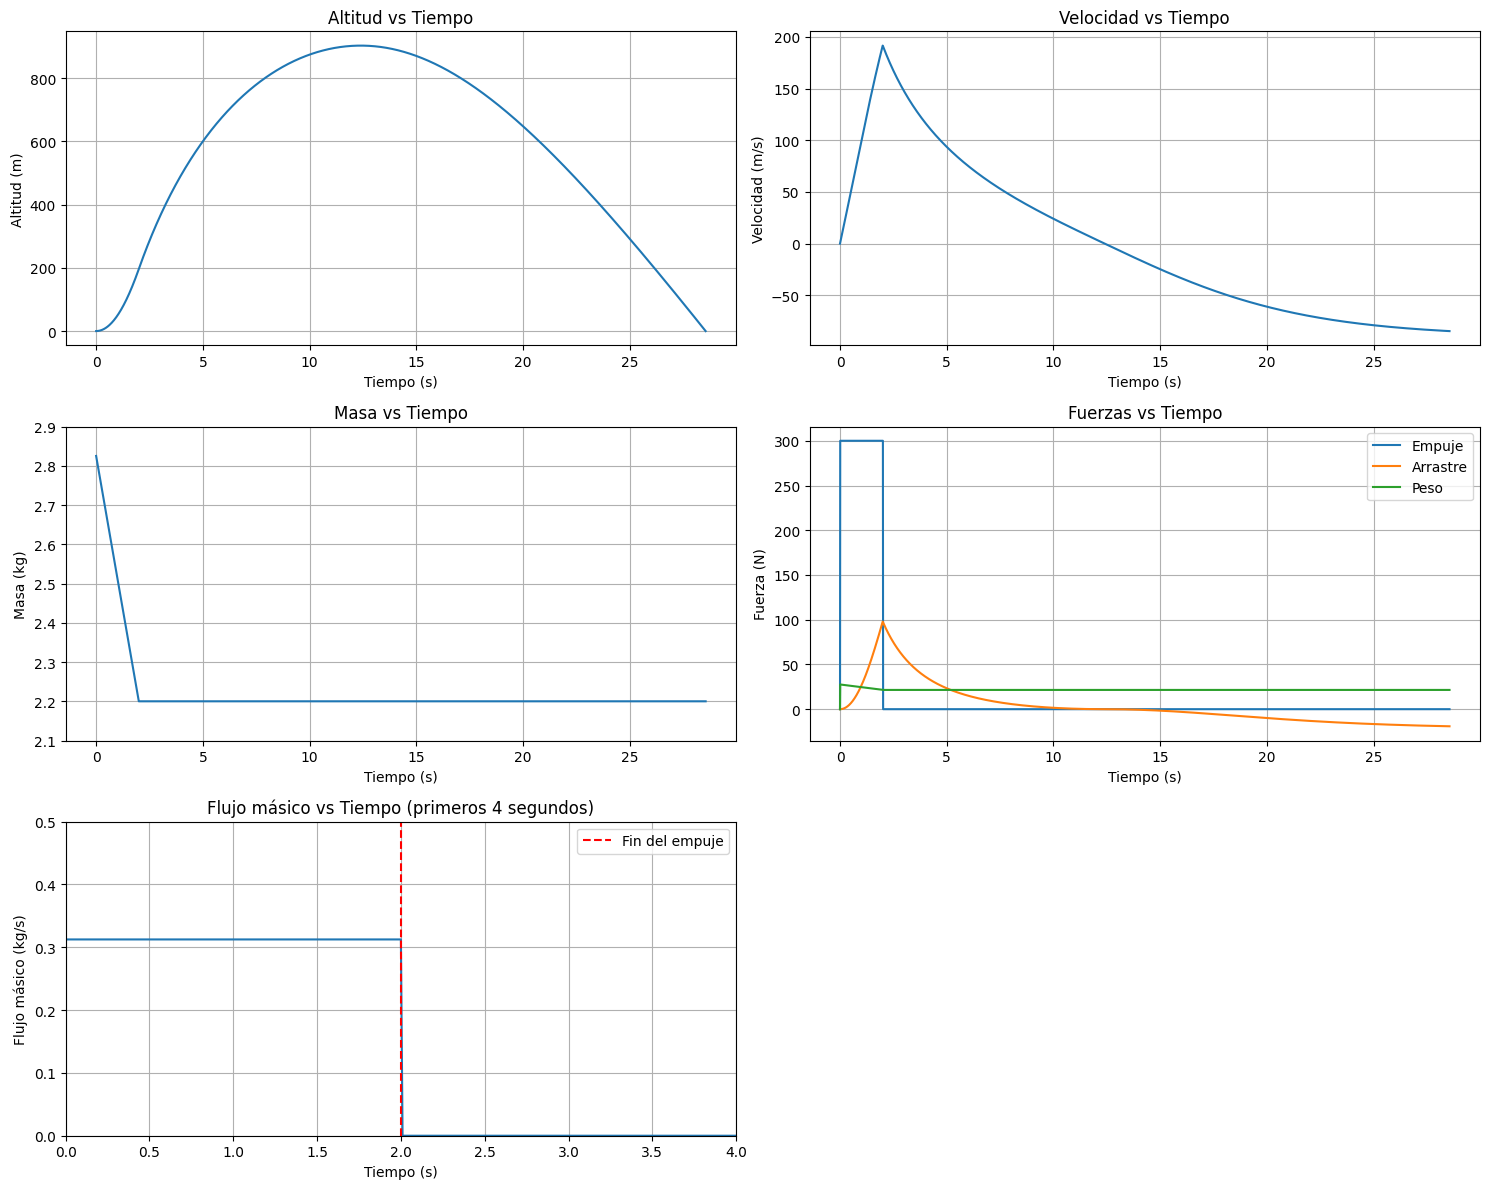

MECO (Corte del Motor Principal):
  Tiempo: 2.01 s
  Altitud: 198.25 m
  Velocidad: 191.18 m/s

Apogeo:
  Tiempo: 12.40 s
  Altitud: 903.47 m
  Velocidad: 0.01 m/s

Valores máximos:
  Altitud máxima: 903.47 m
  Velocidad máxima: 191.50 m/s
  Aceleración máxima: 100.42 m/s^2

Tiempo de vuelo: 28.56 s


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
g = 9.78  # aceleración gravitacional [m/s^2]
rho = 1.225  # densidad del aire al nivel del mar [kg/m^3]

# Parámetros del cohete
diametro_fuselaje = 0.086  # diámetro del fuselaje [m]
A = np.pi * (diametro_fuselaje / 2)**2  # área de referencia [m^2]
Cd = 0.75  # coeficiente de arrastre

# Masa inicial y masa seca
m_0 = 2.825  # masa inicial [kg] (masa junto con propelente)
masa_seca = 2.2  # Masa seca del cohete [kg]

# Condiciones iniciales
h_0 = 0  # altitud inicial [m]
v_0 = 0  # velocidad inicial [m/s]

# Parámetros de simulación
dt = 0.01  # paso de tiempo [s]
t_max = 150  # tiempo máximo de simulación [s]

# Características del motor
u_e = 960  # velocidad de escape [m/s]

# Función de flujo másico
def flujo_masico(t):
    if 0 <= t <= 2:
        return 5 / 16
    else:
        return 0

# Función para calcular las derivadas
def derivadas(t, y):
    h, v, m = y
    m_punto = flujo_masico(t)
    T = m_punto * u_e
    D = 0.5 * rho * v * abs(v) * Cd * A
    dh_dt = v
    dv_dt = (T - D - m * g) / m
    dm_dt = -m_punto
    return np.array([dh_dt, dv_dt, dm_dt])

# Método de Runge-Kutta de cuarto orden (RK4)
def rk4_step(t, y, dt):
    k1 = derivadas(t, y)
    k2 = derivadas(t + 0.5*dt, y + 0.5*dt*k1)
    k3 = derivadas(t + 0.5*dt, y + 0.5*dt*k2)
    k4 = derivadas(t + dt, y + dt*k3)
    return y + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

# Inicializar arreglos
t_arreglo = np.arange(0, t_max, dt)
h_arreglo = np.zeros_like(t_arreglo)
v_arreglo = np.zeros_like(t_arreglo)
m_arreglo = np.zeros_like(t_arreglo)
a_arreglo = np.zeros_like(t_arreglo)
T_arreglo = np.zeros_like(t_arreglo)
D_arreglo = np.zeros_like(t_arreglo)
W_arreglo = np.zeros_like(t_arreglo)
m_punto_arreglo = np.array([flujo_masico(t) for t in t_arreglo])

# Valores iniciales
y = np.array([h_0, v_0, m_0])
h_arreglo[0], v_arreglo[0], m_arreglo[0] = y

# Bucle de simulación
for i in range(1, len(t_arreglo)):
    t = t_arreglo[i-1]
    y = rk4_step(t, y, dt)
    y[2] = max(y[2], masa_seca)  # Asegurarse de que la masa no sea menor que la masa seca

    # Almacenar resultados
    h_arreglo[i], v_arreglo[i], m_arreglo[i] = y

    # Calcular parámetros adicionales
    m_punto = flujo_masico(t)
    T = m_punto * u_e
    D = 0.5 * rho * v_arreglo[i] * abs(v_arreglo[i]) * Cd * A
    W = m_arreglo[i] * g
    a = (T - D - W) / m_arreglo[i]

    T_arreglo[i] = T
    D_arreglo[i] = D
    W_arreglo[i] = W
    a_arreglo[i] = a

    # Verificar si el cohete ha aterrizado
    if h_arreglo[i] <= 0 and i > 1:
        t_arreglo = t_arreglo[:i+1]
        h_arreglo = h_arreglo[:i+1]
        v_arreglo = v_arreglo[:i+1]
        m_arreglo = m_arreglo[:i+1]
        a_arreglo = a_arreglo[:i+1]
        T_arreglo = T_arreglo[:i+1]
        D_arreglo = D_arreglo[:i+1]
        W_arreglo = W_arreglo[:i+1]
        m_punto_arreglo = m_punto_arreglo[:i+1]
        break

# Encontrar puntos importantes
indices_meco = np.where(np.diff(T_arreglo) < 0)[0]
if len(indices_meco) > 0:
    indice_meco = indices_meco[0]
else:
    indice_meco = -1

indice_apogeo = np.argmax(h_arreglo)

# Gráficas
plt.figure(figsize=(15, 12))

# Altitud vs Tiempo
plt.subplot(3, 2, 1)
plt.plot(t_arreglo, h_arreglo)
plt.title('Altitud vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Altitud (m)')
plt.grid(True)

# Velocidad vs Tiempo
plt.subplot(3, 2, 2)
plt.plot(t_arreglo, v_arreglo)
plt.title('Velocidad vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.grid(True)

# Masa vs Tiempo
plt.subplot(3, 2, 3)
plt.plot(t_arreglo, m_arreglo)
plt.title('Masa vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Masa (kg)')
plt.ylim(2.1, 2.9)
plt.grid(True)

# Fuerzas vs Tiempo
plt.subplot(3, 2, 4)
plt.plot(t_arreglo, T_arreglo, label='Empuje')
plt.plot(t_arreglo, D_arreglo, label='Arrastre')
plt.plot(t_arreglo, W_arreglo, label='Peso')
plt.title('Fuerzas vs Tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Fuerza (N)')
plt.legend()
plt.grid(True)

# Flujo másico vs Tiempo (primeros 4 segundos)
plt.subplot(3, 2, 5)
t_flujo = t_arreglo[t_arreglo <= 4]
m_punto_flujo = m_punto_arreglo[t_arreglo <= 4]
plt.plot(t_flujo, m_punto_flujo)
plt.title('Flujo másico vs Tiempo (primeros 4 segundos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Flujo másico (kg/s)')
plt.xlim(0, 4)  # Establecer el límite del eje x a 4 segundos
plt.ylim(0, 0.5)  # Ajustado para mostrar mejor el flujo másico
plt.grid(True)

# Añadir una línea vertical en t=2s para marcar el fin del empuje
plt.axvline(x=2, color='r', linestyle='--', label='Fin del empuje')
plt.legend()

plt.tight_layout()
plt.show()

# Imprimir resultados
print(f"MECO (Corte del Motor Principal):")
if indice_meco != -1:
    print(f"  Tiempo: {t_arreglo[indice_meco]:.2f} s")
    print(f"  Altitud: {h_arreglo[indice_meco]:.2f} m")
    print(f"  Velocidad: {v_arreglo[indice_meco]:.2f} m/s")
else:
    print("  El motor principal no se apaga durante la simulación.")

print(f"\nApogeo:")
print(f"  Tiempo: {t_arreglo[indice_apogeo]:.2f} s")
print(f"  Altitud: {h_arreglo[indice_apogeo]:.2f} m")
print(f"  Velocidad: {v_arreglo[indice_apogeo]:.2f} m/s")

print(f"\nValores máximos:")
print(f"  Altitud máxima: {np.max(h_arreglo):.2f} m")
print(f"  Velocidad máxima: {np.max(v_arreglo):.2f} m/s")
print(f"  Aceleración máxima: {np.max(np.abs(a_arreglo)):.2f} m/s^2")

print(f"\nTiempo de vuelo: {t_arreglo[-1]:.2f} s")
